# Notebook de importação e Depuração dos datasets

#### Criação de um objeto spark

In [1]:
#import findspark
#findspark.init()
#findspark.find()

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import to_date
from pyspark.sql.functions import round
import pyspark.sql.functions as F
import seaborn as sns
from collections import Counter

# Importação das bibliotecas necessárias para modelos
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt


# build our SparkSession
spark = SparkSession\
        .builder\
        .appName("BigData")\
        .config("spark.sql.shuffle.partitions",6)\
        .config("spark.sql.repl.eagereval.enabled",True)\
        .getOrCreate()

In [2]:
spark

In [3]:
pwd

'/home/jovyan/code/Projeto/Notebooks'

In [4]:
#Ler o dataset a usar
! ls -la ../Datasets/

total 346244
drwxrwxrwx 1 root   root       4096 Jun 10 23:09 .
drwxrwxrwx 1 root   root       4096 Jun 10 23:09 ..
-rwxrwxrwx 1 root   root     130703 May 25 09:21 acorn_details.csv
drwxr-xr-x 1 jovyan users      4096 Jun 10 21:38 cold_df_parquet.parquet
drwxr-xr-x 1 jovyan users      4096 Jun 10 22:04 cold_pipeline
drwxrwxrwx 1 root   root       4096 May 25 09:21 daily_dataset
-rwxrwxrwx 1 root   root  351799634 May 25 09:21 daily_dataset.csv
drwxr-xr-x 1 jovyan users      4096 Jun 10 21:32 energy_households_parquet.parquet
drwxrwxrwx 1 root   root       4096 May 25 09:21 halfhourly_dataset
drwxrwxrwx 1 root   root       4096 May 25 09:22 hhblock_dataset
drwxr-xr-x 1 jovyan users      4096 Jun 10 23:09 hot_clusters.csv
drwxr-xr-x 1 jovyan users      4096 Jun 10 21:37 hot_df_parquet.parquet
drwxr-xr-x 1 jovyan users      4096 Jun 10 21:52 hot_pipeline
-rwxrwxrwx 1 root   root     234595 May 25 09:22 informations_households.csv
drwxr-xr-x 1 jovyan users      4096 Jun 10 21:39 kmeans_pi

In [5]:
ficheiro = "../Datasets/energy_households_parquet.parquet/"

# Ler os dados Parquet
df = spark.read.parquet(ficheiro)

In [6]:
# Mostrar a base de dados até agora
df.printSchema()

root
 |-- household_id: string (nullable = true)
 |-- date: date (nullable = true)
 |-- energy_median: float (nullable = true)
 |-- energy_mean: float (nullable = true)
 |-- energy_max: float (nullable = true)
 |-- energy_std: float (nullable = true)
 |-- energy_sum: float (nullable = true)
 |-- energy_min: float (nullable = true)
 |-- tax_type: string (nullable = true)
 |-- acorn_groups: string (nullable = true)
 |-- status: string (nullable = true)
 |-- is_summer: integer (nullable = true)



In [7]:
# Mostrar as primeiras 5 linhas
df.show(5)

+------------+----------+-------------+-----------+----------+----------+----------+----------+--------+------------+---------+---------+
|household_id|      date|energy_median|energy_mean|energy_max|energy_std|energy_sum|energy_min|tax_type|acorn_groups|   status|is_summer|
+------------+----------+-------------+-----------+----------+----------+----------+----------+--------+------------+---------+---------+
|   MAC003215|2012-10-26|        0.161|      0.217|     1.259|     0.192|    10.423|     0.085|     Std|     ACORN-N|Adversity|        0|
|   MAC001423|2012-11-20|        0.116|      0.165|     0.628|     0.115|      7.93|     0.107|     Std|     ACORN-L|Adversity|        0|
|   MAC004177|2012-12-04|          0.2|       0.22|     0.491|     0.077|    10.568|     0.114|     Std|     ACORN-L|Adversity|        0|
|   MAC002551|2012-09-11|         0.13|      0.156|     0.749|     0.117|     7.511|     0.051|     Std|     ACORN-Q|Adversity|        1|
|   MAC005195|2013-11-05|        0

## Preparação para a Modelagem

Nesta fase, será preparada a base de dados para a execução dos modelos. A base de dados será dividida em 2 bases de dados mais pequenas:

- Base de dados com a distribuição do consumo de energia por household_id, separada pelos meses quentes 

- Base de dados com a distribuição do consumo de energia por household_id, separada pelos meses frios
<br>

A divisão da base de dados inicial desta forma proporcionará uma observação mais eloquente e esclarecida da informação disposta, permitindo descobrir os padrões de consumo dos consumidores de energia, sem a influência de fatores externos 

<!-- <br> -->

### Divisões das bases de dados

In [8]:
# Filtrar a base de dados apenas com:

# Meses quentes
df_hot = df.select("*").where(df["is_summer"] == 1)

# Meses frios 
df_cold = df.select("*").where(df["is_summer"] == 0)


In [9]:
df_hot.count()

973427

In [10]:
# Bases de dados apenas com household_id únicos:

# Para meses quentes 
df_hot_unique = df_hot.groupBy("household_id").agg(
    F.avg("energy_median").alias("avg_energy_median_mean"),
    F.avg("energy_mean").alias("avg_energy_mean"),
    F.avg("energy_max").alias("avg_energy_max"),
    F.avg("energy_std").alias("avg_energy_std"),
    F.avg("energy_sum").alias("avg_energy_sum"),
    F.avg("energy_min").alias("avg_energy_min"),
    F.first("status").alias("status"),
    F.first("tax_type").alias("tax_type"),
).orderBy("household_id")
    
# Arredondar
for col in ["avg_energy_median_mean",
             "avg_energy_mean", 
             "avg_energy_max", 
             "avg_energy_std", 
             "avg_energy_sum",
             "avg_energy_min"]:
    df_hot_unique = df_hot_unique.withColumn(
        col, round(df_hot_unique[col], 5))


# Para meses frios 
df_cold_unique = df_cold.groupBy("household_id").agg(
    F.avg("energy_median").alias("avg_energy_median_mean"),
    F.avg("energy_mean").alias("avg_energy_mean"),
    F.avg("energy_max").alias("avg_energy_max"),
    F.avg("energy_std").alias("avg_energy_std"),
    F.avg("energy_sum").alias("avg_energy_sum"),
    F.avg("energy_min").alias("avg_energy_min"),
    F.first("status").alias("status"),
    F.first("tax_type").alias("tax_type"),
    ).orderBy("household_id")
    
# Arredondar
for col in ["avg_energy_median_mean",
             "avg_energy_mean", 
             "avg_energy_max", 
             "avg_energy_std", 
             "avg_energy_sum",
             "avg_energy_min"]:
    df_cold_unique = df_cold_unique.withColumn(
        col, round(df_cold_unique[col], 5))


In [11]:
df_hot_unique.show(5)
df_cold_unique.show(5)

+------------+----------------------+---------------+--------------+--------------+--------------+--------------+---------+--------+
|household_id|avg_energy_median_mean|avg_energy_mean|avg_energy_max|avg_energy_std|avg_energy_sum|avg_energy_min|   status|tax_type|
+------------+----------------------+---------------+--------------+--------------+--------------+--------------+---------+--------+
|   MAC000002|               0.14613|        0.19541|       0.92178|       0.15687|       9.37931|        0.0783| Affluent|     Std|
|   MAC000003|               0.16237|        0.25848|       1.48736|       0.30136|      12.40402|       0.05085|Adversity|     Std|
|   MAC000004|                4.1E-4|         0.0322|       0.22853|       0.06878|       1.54081|        2.0E-4| Affluent|     Std|
|   MAC000005|               0.04213|        0.07749|        0.4381|       0.08009|        3.7062|       0.03074| Affluent|     ToU|
|   MAC000006|               0.04555|        0.05392|       0.23077| 

<br>

## Divisão dos Datasets em conjuntos de Treino e Teste

In [12]:
# Dividir as bses de dados em conjuntos de treino e teste

# Meses quentes 
df_hot_train, df_hot_test = df_hot_unique.randomSplit([0.8, 0.2],68)

# Meses frios 
df_cold_train, df_cold_test  = df_cold_unique.randomSplit([0.8, 0.2],68)


In [13]:
# Em meses quentes:
print(f" Referente aos meses quentes, existem {df_hot_train.count()} linhas no training set e {df_hot_test.count()} linhas no test set.")

 Referente aos meses quentes, existem 4417 linhas no training set e 1120 linhas no test set.


In [14]:
# Em meses frios: 
print(f" Referente aos meses frios, existem {df_cold_train.count()} linhas no training set e {df_cold_test.count()} linhas no test set.")


 Referente aos meses frios, existem 4416 linhas no training set e 1120 linhas no test set.


#### Guardar os conjuntos de teste localmente em parquet

In [15]:
# Criação de partições para aumentar o paralelismo
df_hot_test_parquet = df_hot_test.repartition(200)
df_cold_test_parquet = df_cold_test.repartition(200)

# Guardar os conjuntos de teste em parquet
path_hot = '../Datasets/hot_df_parquet.parquet'
path_cold = '../Datasets/cold_df_parquet.parquet'
df_hot_test_parquet.write.mode("overwrite").parquet(path_hot)
df_cold_test_parquet.write.mode("overwrite").parquet(path_cold)

<br>

### Criação das variáveis "tax_type" e "status", enconded

In [16]:
# Indexação das variáveis categóricas
indexer = StringIndexer(inputCols=["status", "tax_type"], outputCols=["status_indexed", "tax_type_indexed"])
df_indexed = indexer.fit(df).transform(df)

# Aplicação do OneHotEncoder
encoder = OneHotEncoder(inputCols=["status_indexed", "tax_type_indexed"], outputCols=["status_encoded", "tax_type_encoded"])
df_encoded = encoder.fit(df_indexed).transform(df_indexed)


In [17]:
# Configurar um pipeline para implementar as indexações das variáveis status_encoded e tax_type_encoded

assembler = VectorAssembler(
    inputCols=["avg_energy_median_mean", "avg_energy_mean", "avg_energy_max",
               "avg_energy_std", "avg_energy_sum", "avg_energy_min", "status_encoded", "tax_type_encoded"],
    outputCol="unscaled_features"
)


In [18]:
# Estandadizar as variáves
scaler = StandardScaler(inputCol="unscaled_features", outputCol="scaled_features")

In [19]:
# Configuração do Pipeline
pipeline_variables_encoded = Pipeline(stages=[indexer, encoder, assembler, scaler])

In [20]:
# Ajustar o Pipeline aos DataFrames
encoded_hot = pipeline_variables_encoded.fit(df_hot_train)
encoded_cold = pipeline_variables_encoded.fit(df_cold_train)


In [21]:
#Transformar os DataFrames
transformed_hot_df = encoded_hot.transform(df_hot_train)
transformed_cold_df = encoded_cold.transform(df_cold_train)

transformed_hot_df.show(3)
transformed_cold_df.show(3)

+------------+----------------------+---------------+--------------+--------------+--------------+--------------+-----------+--------+--------------+----------------+--------------+----------------+--------------------+--------------------+
|household_id|avg_energy_median_mean|avg_energy_mean|avg_energy_max|avg_energy_std|avg_energy_sum|avg_energy_min|     status|tax_type|status_indexed|tax_type_indexed|status_encoded|tax_type_encoded|   unscaled_features|     scaled_features|
+------------+----------------------+---------------+--------------+--------------+--------------+--------------+-----------+--------+--------------+----------------+--------------+----------------+--------------------+--------------------+
|   MAC000002|               0.14613|        0.19541|       0.92178|       0.15687|       9.37931|        0.0783|   Affluent|     Std|           0.0|             0.0| (3,[0],[1.0])|   (1,[0],[1.0])|[0.14613,0.19541,...|[1.97496818848237...|
|   MAC000006|               0.04555

#### Guardar a pipeline para a transformação do dataset

In [22]:
# Diretório para salvar a pipeline de transformação
variables_pipeline_path = '../Datasets/variables_transformation_pipeline'

# Salvar a pipeline
pipeline_variables_encoded.write().overwrite().save(variables_pipeline_path)

## Criação da Pipeline do algoritmo K-means

### Criação do Modelo (KMeans)

In [23]:
# Criação do modelo kmeans:
km = KMeans(featuresCol = 'scaled_features')



<br>

### Estruturação da Pipeline

In [24]:
# Estruturação da Pipeline
kmeans_pipeline = Pipeline(stages=[km])

### Salvar a Pipeline no disco

In [25]:
# Diretório para salvar a pipeline
kmeans_pipeline_path = '../Datasets/kmeans_pipeline'

# Salvar a pipeline
kmeans_pipeline.write().overwrite().save(kmeans_pipeline_path)

###  Aplicação da Pipeline sobre a base de dados de Verão para obter clusters

In [26]:
# Avaliador para calcular o Silhouette Score
evaluator = ClusteringEvaluator(featuresCol="scaled_features", metricName="silhouette", distanceMeasure="squaredEuclidean")

def evaluate_k_values(df, k_range):
    scores = []
    for k in k_range:
        kmeans = KMeans(featuresCol="scaled_features", k=k, seed=42)
        model = kmeans.fit(df)
        predictions = model.transform(df)
        score = evaluator.evaluate(predictions)
        scores.append((k, score))
        print(f"Silhouette Score for k={k}: {score}")
    return scores

###  Aplicação da Pipeline sobre a base de dados de Verão para obter clusters

Silhouette Score for k=2: 0.4857103472381657
Silhouette Score for k=3: 0.3871701333299098
Silhouette Score for k=4: 0.49643363304325877
Silhouette Score for k=5: 0.4689102016874499
Silhouette Score for k=6: 0.47360039815306987
Silhouette Score for k=7: 0.482704222739195
Silhouette Score for k=8: 0.4954238587855474
Silhouette Score for k=9: 0.5140064779448958
Silhouette Score for k=10: 0.41797421226826076
Silhouette Score for k=11: 0.5354678938934043
Silhouette Score for k=12: 0.5195608191679323
Silhouette Score for k=13: 0.46893451392661084
Silhouette Score for k=14: 0.5185926560542259
Silhouette Score for k=15: 0.5005801727449168
Silhouette Score for k=16: 0.5018326038954736
Silhouette Score for k=17: 0.4924312639983957
Best k for hot months by Silhouette Score: 11


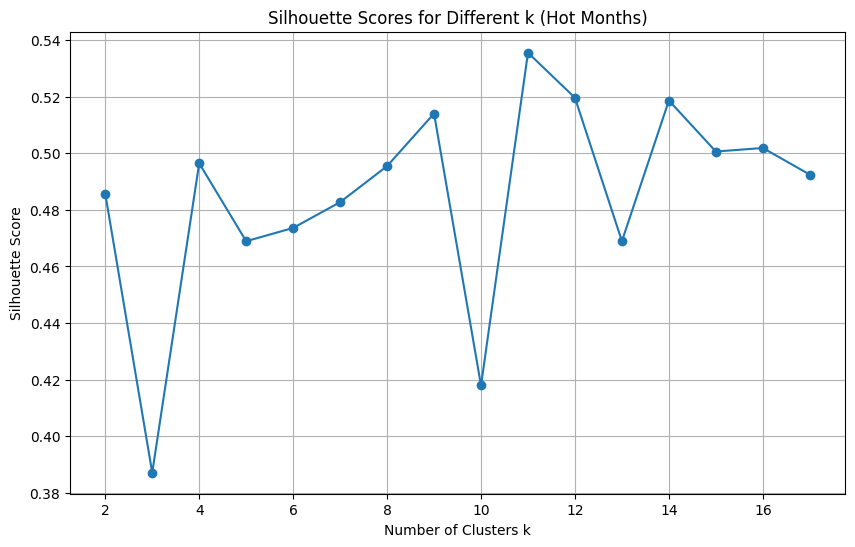

In [27]:
# Clusters para meses quentes
k_range_hot = range(2, 18)  
hot_scores = evaluate_k_values(transformed_hot_df, k_range_hot)

# Encontrar o melhor k para meses quentes
best_k_hot = max(hot_scores, key=lambda x: x[1])[0]
print(f"Best k for hot months by Silhouette Score: {best_k_hot}")

# Assumindo que você já calculou os scores para meses quentes
k_values_hot = [score[0] for score in hot_scores]
silhouette_scores_hot = [score[1] for score in hot_scores]

plt.figure(figsize=(10, 6))
plt.plot(k_values_hot, silhouette_scores_hot, marker='o')
plt.xlabel('Number of Clusters k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different k (Hot Months)')
plt.grid(True)
plt.show()

In [28]:
# Aplicação do modelo nos dados de treino da bse de dados com o k escolhido
kmeans_pipeline.getStages()[-1].setK(best_k_hot).setSeed(1)  

# Aplicação dos dados de treino referentes aos meses quentes na 
# pipeline, para o melhor k selecionado
model_hot = kmeans_pipeline.fit(transformed_hot_df)
clusters_hot = model_hot.transform(transformed_hot_df)
clusters_hot.show(5)



+------------+----------------------+---------------+--------------+--------------+--------------+--------------+-----------+--------+--------------+----------------+--------------+----------------+--------------------+--------------------+----------+
|household_id|avg_energy_median_mean|avg_energy_mean|avg_energy_max|avg_energy_std|avg_energy_sum|avg_energy_min|     status|tax_type|status_indexed|tax_type_indexed|status_encoded|tax_type_encoded|   unscaled_features|     scaled_features|prediction|
+------------+----------------------+---------------+--------------+--------------+--------------+--------------+-----------+--------+--------------+----------------+--------------+----------------+--------------------+--------------------+----------+
|   MAC000002|               0.14613|        0.19541|       0.92178|       0.15687|       9.37931|        0.0783|   Affluent|     Std|           0.0|             0.0| (3,[0],[1.0])|   (1,[0],[1.0])|[0.14613,0.19541,...|[1.97496818848237...|    

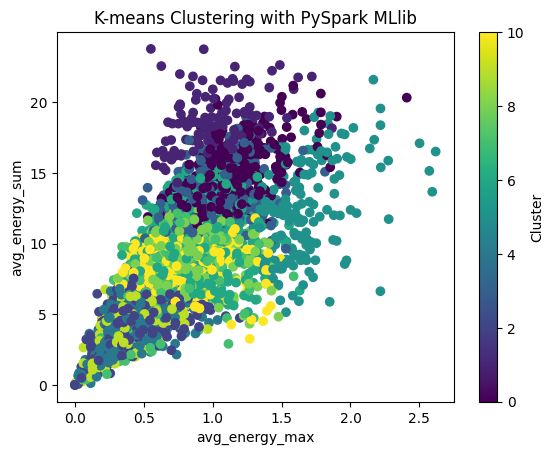

In [29]:
# Preparação para a visualização dos dados
vis_df_hot = clusters_hot.toPandas()

# Gráfico que mostra os clusters entre as variáveis avg_energy_max e avg_energy_sum
plt.scatter(vis_df_hot["avg_energy_max"], vis_df_hot["avg_energy_sum"], c=vis_df_hot["prediction"], cmap='viridis')
plt.xlabel("avg_energy_max")
plt.ylabel("avg_energy_sum")
plt.title("K-means Clustering with PySpark MLlib")
plt.colorbar().set_label("Cluster")
plt.show()

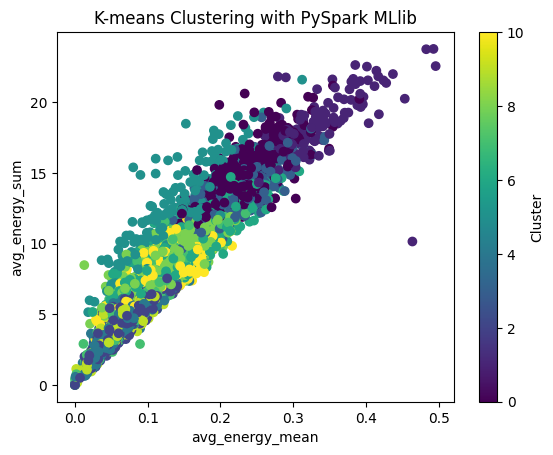

In [30]:
# Gráfico que mostra os clusters entre as variáveis avg_energy_median_mean e avg_energy_sum
plt.scatter(vis_df_hot["avg_energy_median_mean"], vis_df_hot["avg_energy_sum"], c=vis_df_hot["prediction"], cmap='viridis')
plt.xlabel("avg_energy_mean")
plt.ylabel("avg_energy_sum")
plt.title("K-means Clustering with PySpark MLlib")
plt.colorbar().set_label("Cluster")
plt.show()

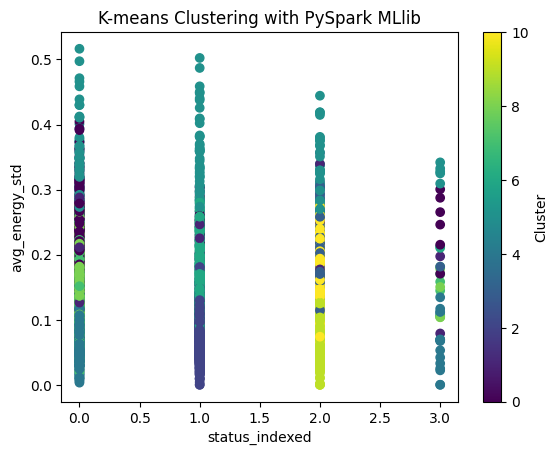

In [31]:
# Gráfico que mostra os clusters entre as variáveis status_indexed e avg_energy_std
plt.scatter(vis_df_hot["status_indexed"], vis_df_hot["avg_energy_std"], c=vis_df_hot["prediction"], cmap='viridis')
plt.xlabel("status_indexed")
plt.ylabel("avg_energy_std")
plt.title("K-means Clustering with PySpark MLlib")
plt.colorbar().set_label("Cluster")
plt.show()

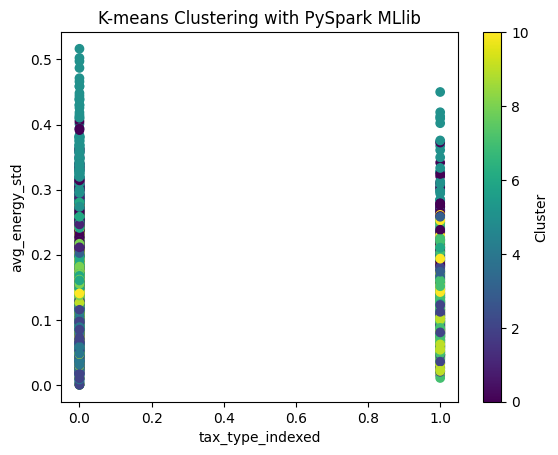

In [32]:
# Gráfico que mostra os clusters entre as variáveis tax_type_indexed e avg_energy_std
plt.scatter(vis_df_hot["tax_type_indexed"], vis_df_hot["avg_energy_std"], c=vis_df_hot["prediction"], cmap='viridis')
plt.xlabel("tax_type_indexed")
plt.ylabel("avg_energy_std")
plt.title("K-means Clustering with PySpark MLlib")
plt.colorbar().set_label("Cluster")
plt.show()

In [33]:
#Número de observações por Cluster
clusters_hot.select("prediction").groupBy("prediction").count().orderBy("prediction", ascending=True).show(truncate=False)

+----------+-----+
|prediction|count|
+----------+-----+
|0         |309  |
|1         |115  |
|2         |840  |
|3         |225  |
|4         |594  |
|5         |169  |
|6         |506  |
|7         |304  |
|8         |451  |
|9         |460  |
|10        |444  |
+----------+-----+



#### Guardar localmente a pipeline do modelo para os dados de verão

In [34]:
# Diretório para salvar a pipeline
pipeline_path = '../Datasets/hot_pipeline'

# Salvar a pipeline ajustada
model_hot.write().overwrite().save(pipeline_path)

### Aplicação da pipeline sobre a base de dados de Inverno para obter clusters

Selecionar o melhor valor para k:

Silhouette Score for k=2: 0.4724004272005879
Silhouette Score for k=3: 0.2840837758059476
Silhouette Score for k=4: 0.4740507516487535
Silhouette Score for k=5: 0.46688443006295793
Silhouette Score for k=6: 0.4657855202280449
Silhouette Score for k=7: 0.44697396423193914
Silhouette Score for k=8: 0.4953517567208376
Silhouette Score for k=9: 0.5165869366048094
Silhouette Score for k=10: 0.5140217028392161
Silhouette Score for k=11: 0.5320235549042605
Silhouette Score for k=12: 0.4797053863311465
Silhouette Score for k=13: 0.47355135465650805
Silhouette Score for k=14: 0.46489665854591655
Silhouette Score for k=15: 0.46837037213796634
Silhouette Score for k=16: 0.5121307928387727
Silhouette Score for k=17: 0.5218353003105254
Best k for cold months by Silhouette Score: 11


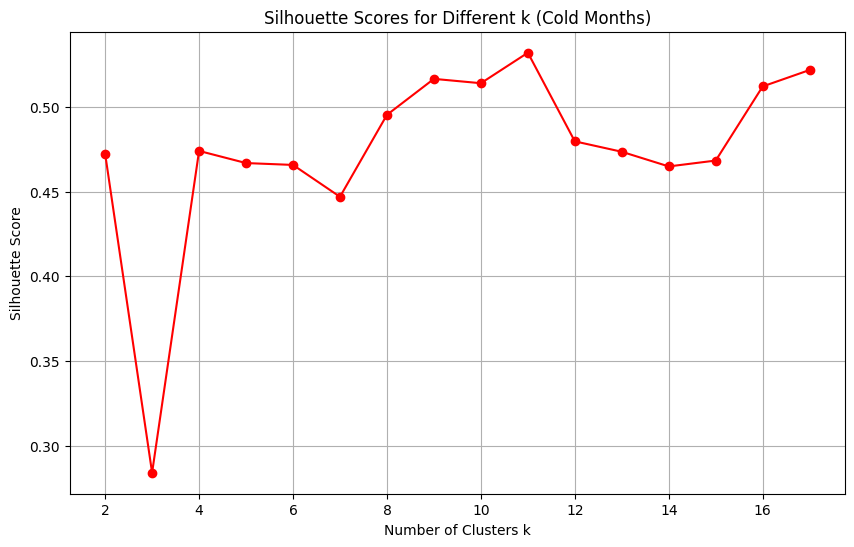

In [35]:
#Clusters para meses frios
# Assumindo que 'preprocessed_cold_data' é o DataFrame com dados pre-processados para meses frios
k_range_cold = range(2, 18)  
cold_scores = evaluate_k_values(transformed_cold_df, k_range_cold)

# Encontrar o melhor k para meses frios
best_k_cold = max(cold_scores, key=lambda x: x[1])[0]
print(f"Best k for cold months by Silhouette Score: {best_k_cold}")

# Assumindo que você já calculou os scores para meses frios
k_values_cold = [score[0] for score in cold_scores]
silhouette_scores_cold = [score[1] for score in cold_scores]

plt.figure(figsize=(10, 6))
plt.plot(k_values_cold, silhouette_scores_cold, marker='o', color='red')  # Usar uma cor diferente para destaque
plt.xlabel('Number of Clusters k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different k (Cold Months)')
plt.grid(True)
plt.show()

In [36]:
# Aplicaçãpo do modelo nos dados de treino da base de dados de inverno com o k escolhido
kmeans_pipeline.getStages()[-1].setK(best_k_cold).setSeed(1)  

# Aplicação dos dados de treino referentes aos meses frios na 
# pipeline, para o melhor k selecionado
model_cold = kmeans_pipeline.fit(transformed_cold_df)
clusters_cold = model_cold.transform(transformed_cold_df)
clusters_cold.show(5)

+------------+----------------------+---------------+--------------+--------------+--------------+--------------+-----------+--------+--------------+----------------+--------------+----------------+--------------------+--------------------+----------+
|household_id|avg_energy_median_mean|avg_energy_mean|avg_energy_max|avg_energy_std|avg_energy_sum|avg_energy_min|     status|tax_type|status_indexed|tax_type_indexed|status_encoded|tax_type_encoded|   unscaled_features|     scaled_features|prediction|
+------------+----------------------+---------------+--------------+--------------+--------------+--------------+-----------+--------+--------------+----------------+--------------+----------------+--------------------+--------------------+----------+
|   MAC000002|               0.18796|        0.25911|       1.10509|       0.21561|      12.42996|       0.07642|   Affluent|     Std|           0.0|             0.0| (3,[0],[1.0])|   (1,[0],[1.0])|[0.18796,0.25911,...|[2.26008654345655...|    

In [37]:
#Número de observaçõe por Cluster
clusters_cold.select("prediction").groupBy("prediction").count().orderBy("prediction", ascending=True).show(truncate=False)

+----------+-----+
|prediction|count|
+----------+-----+
|0         |294  |
|1         |425  |
|2         |749  |
|3         |464  |
|4         |239  |
|5         |515  |
|6         |550  |
|7         |307  |
|8         |210  |
|9         |471  |
|10        |192  |
+----------+-----+



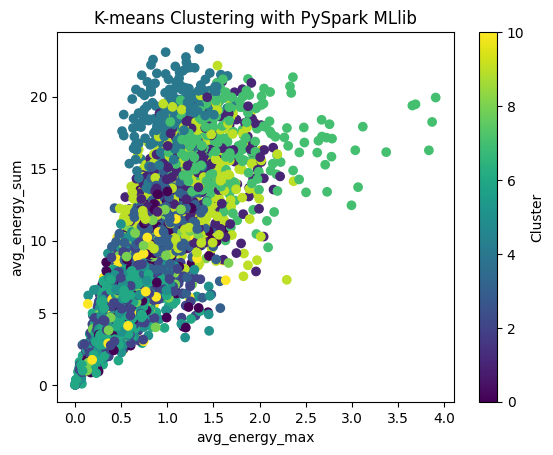

In [38]:
# Preparação para a visualização dos dados
vis_df_cold = clusters_cold.toPandas()

# Gráfico que mostra os clusters entre as variáveis avg_energy_max e avg_energy_sum
plt.scatter(vis_df_cold["avg_energy_max"], vis_df_cold["avg_energy_sum"], c=vis_df_cold["prediction"], cmap='viridis')
plt.xlabel("avg_energy_max")
plt.ylabel("avg_energy_sum")
plt.title("K-means Clustering with PySpark MLlib")
plt.colorbar().set_label("Cluster")
plt.show()

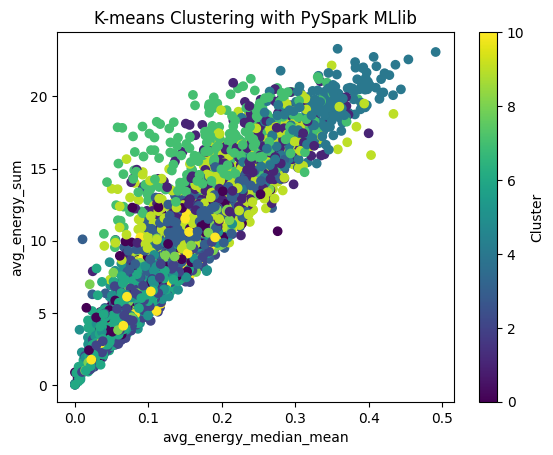

In [39]:
# Gráfico que mostra os clusters entre as variáveis avg_energy_median_mean e avg_energy_sum
plt.scatter(vis_df_cold["avg_energy_median_mean"], vis_df_cold["avg_energy_sum"], c=vis_df_cold["prediction"], cmap='viridis')
plt.xlabel("avg_energy_median_mean")
plt.ylabel("avg_energy_sum")
plt.title("K-means Clustering with PySpark MLlib")
plt.colorbar().set_label("Cluster")
plt.show()

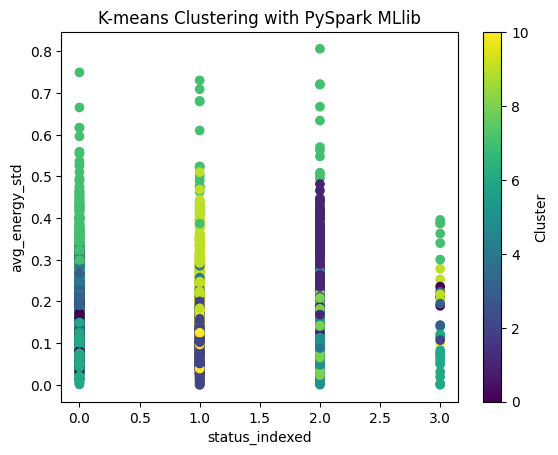

In [40]:
# Gráfico que mostra os clusters entre as variáveis status_indexed e avg_energy_std
plt.scatter(vis_df_cold["status_indexed"], vis_df_cold["avg_energy_std"], c=vis_df_cold["prediction"], cmap='viridis')
plt.xlabel("status_indexed")
plt.ylabel("avg_energy_std")
plt.title("K-means Clustering with PySpark MLlib")
plt.colorbar().set_label("Cluster")
plt.show()

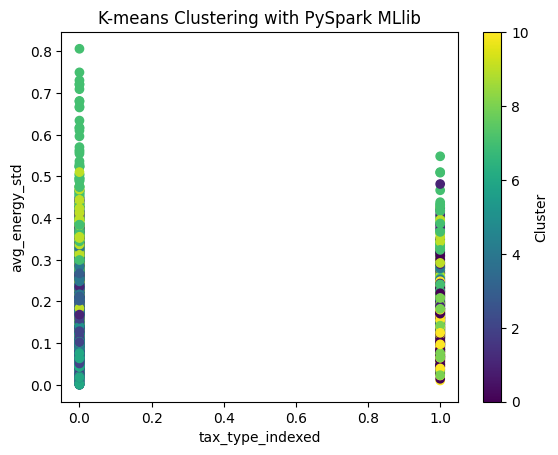

In [41]:
# Gráfico que mostra os clusters entre as variáveis tax_type_indexed e avg_energy_std
plt.scatter(vis_df_cold["tax_type_indexed"], vis_df_cold["avg_energy_std"], c=vis_df_cold["prediction"], cmap='viridis')
plt.xlabel("tax_type_indexed")
plt.ylabel("avg_energy_std")
plt.title("K-means Clustering with PySpark MLlib")
plt.colorbar().set_label("Cluster")
plt.show()

#### Guardar localmente a pipeline para o modelo com os dados de inverno

In [42]:
# Diretório para salvar a pipeline
pipeline_path = '../Datasets/cold_pipeline'

# Salvar a pipeline ajustada
model_cold.write().overwrite().save(pipeline_path)